Epoch 1/15, Last Batch Loss: 1.3185
Epoch 2/15, Last Batch Loss: 0.7928
Epoch 3/15, Last Batch Loss: 0.7791
Epoch 4/15, Last Batch Loss: 1.0401
Epoch 5/15, Last Batch Loss: 0.8300
Epoch 6/15, Last Batch Loss: 0.7033
Epoch 7/15, Last Batch Loss: 0.3641
Epoch 8/15, Last Batch Loss: 0.6051
Epoch 9/15, Last Batch Loss: 0.6250
Epoch 10/15, Last Batch Loss: 0.5681
Epoch 11/15, Last Batch Loss: 0.2253
Epoch 12/15, Last Batch Loss: 0.4283
Epoch 13/15, Last Batch Loss: 0.3922
Epoch 14/15, Last Batch Loss: 0.2236
Epoch 15/15, Last Batch Loss: 0.1655


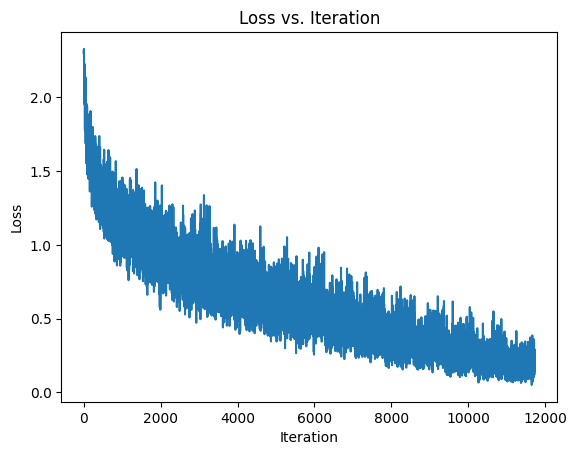

Accuracy: 0.7193, F1-score: 0.7197


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score

# Load CIFAR-10 dataset
data = load_dataset("uoft-cs/cifar10")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Convert Hugging Face dataset to PyTorch Dataset
class CustomData(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset                                 #store hugging face dataset
        self.transform = transform                             #store transformed data(CIFAR10 dataeset transformed to tensors)

    def __len__(self):
        return len(self.dataset)                               #returns number of images(samples) in the dataset

    def __getitem__(self, idx):                                    #gets images and labels from the dataset
        img = self.dataset[idx]["img"]                             #for image
        label = self.dataset[idx]["label"]                         #for corresponding label
        if self.transform:
            img = self.transform(img)                              #apply transformations if available 
        return img, label                                          #returns processed image and label

train_data = CustomData(data["train"], transform=transform)        #get transformed training data(normalization or converting to tensor)
test_data = CustomData(data["test"], transform=transform)          #get transformed testing data(normalization or converting to tensor)

# Create DataLoaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True) #load the training data randomly in batches of 64 
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)  #load the testing data(not random)

# Define CNN model to classify images
class CNN(nn.Module):
    def __init__(self):                                              #initialize layers
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)      #first convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)     #second convolutional layer
        self.pool = nn.MaxPool2d(2, 2)                               
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

                                                                     #fully connected layers only accept 1d vectors
    
    def forward(self, x):                                            #defines how our data moves through the neural network
        x = self.pool(self.relu(self.conv1(x)))                      #conv1 => relu => maxpool
        x = self.pool(self.relu(self.conv2(x)))                      #conv2 => relu => maxpool
        x = torch.flatten(x, start_dim=1)                            #flatten feature maps into 1d vector
        x = self.relu(self.fc1(x))                                   #fc1 => relu
        x = self.fc2(x)                                              #fc2(output)
        return x

# Initialize model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #this executes the code on gpu, if available
model = CNN().to(device)                                              #create instance of CNN and move it to our device(gpu/cpu)
loss_func = nn.CrossEntropyLoss()                                     #for defining our loss function
optimizer = optim.Adam(model.parameters(), lr=0.0005)                 # changed learning rate to 0.0005

# Training loop
epochs = 15                                                           #define number of epochs we want
loss_values = []                                                      #store loss values in list so that we can plot them later
iteration = 0                                                         #keeping track of iterations

for epoch in range(epochs):                                           #creates loop for epoch
    for images, labels in train_loader:                               #loop through mini batches of 64 of our data
        images, labels = images.to(device), labels.to(device)         #moving img, lbls to gpu if available, as we did before

        optimizer.zero_grad()                                         #to clear previous gradients
        outputs = model(images)
        loss = loss_func(outputs, labels)                             #calculates loss 
        loss.backward()                                               #backpropagation
        optimizer.step()                                              #change weights

        loss_values.append(loss.item())                               #store the loss for plotting
        iteration += 1                                                #to calculate loss per iteration
    
    print(f"Epoch {epoch+1}/{epochs}, Last Batch Loss: {loss.item():.4f}")  #prints epoch value, and loss value for last batch evaluated

# Plot loss vs. iteration
plt.plot(range(1, len(loss_values) + 1), loss_values)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss vs. Iteration')
plt.show()

# Evaluate the model
model.eval()
preds, true_labels = [], []

with torch.no_grad():      #switches off grad tracking because here we are just evaluating, this saves memory
    for images, labels in test_loader:                            #loops through test dataset
        images, labels = images.to(device), labels.to(device)     #moves images and labels to gpu(if available), otherwise cpu
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)                      #get class with highest probability
        preds.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

acc = accuracy_score(true_labels, preds)
f1 = f1_score(true_labels, preds, average='macro')

print(f"Accuracy: {acc:.4f}, F1-score: {f1:.4f}")                 #prints final accuracy and f1 score
